In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import basedosdados as bd
import folium
from folium.plugins import HeatMap
import chardet

## Análise exploratória


In [65]:
# Verificar a quantidades de nulls na tabela

query =  """
WITH radares_filtrados AS (
    SELECT *
    FROM `rj-cetrio.desafio.readings_2024_06`
    WHERE camera_latitude BETWEEN -23.100466 AND -22.767821
      AND camera_longitude BETWEEN -43.807011 AND -43.152521
)
select
    count (case when placa is null then 1 end) as null_placa,
    count (case when datahora is null then 1 end) as null_datahora,
    count (case when camera_latitude is null then 1 end) as null_camera_latitude,
    count (case when camera_longitude is null then 1 end) as null_camera_longitude,
    count (case when datahora_captura is null then 1 end) as null_datahora_captura
from
    radares_filtrados;
"""
df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df



Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.63rows/s]


,null_placa,null_datahora,null_camera_latitude,null_camera_longitude,null_datahora_captura
0,0,0,0,0,1787908


## Analisando as câmeras

In [36]:
query = '''
select
    to_base64(camera_numero) as cameras,
    camera_latitude as lat,
    camera_longitude as long,
    count(*) as numero_registros
from
    `rj-cetrio.desafio.readings_2024_06`
group by
    cameras, lat, long
order by
    numero_registros desc;
'''


df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df


Downloading: 100%|██████████| 1421/1421 [00:00<00:00, 5450.02rows/s]


,cameras,lat,long,numero_registros
0,9rbv9sPFeA==,0.000000,0.000000,242301
1,SOVI3/WkTw==,-22.817610,-43.307088,127557
2,F/uPMaEYRA==,-22.862674,-43.247899,126151
3,pvIqO/hltg==,-22.841522,-43.371286,124780
4,PC8tM7HhQQ==,-22.817388,-43.307320,121282
...,...,...,...,...
1416,UNDNP2VA/A==,-22.909231,-43.189613,3
1417,rl6StfoCTA==,-22.916242,-43.212035,2
1418,RX7lnN5tkg==,-22.906111,-43.684444,1
1419,uwWfVsz14w==,-22.907500,-43.198333,1


In [33]:
# Criar um mapa centrado nas coordenadas médias
mapa = folium.Map(location=[df['lat'].mean(), df['long'].mean()], zoom_start=12)

# Adicionar marcadores ao mapa
for index, row in df.iterrows():
    folium.Marker([row['lat'], row['long']], popup=row['cameras']).add_to(mapa)

# Exibir o mapa
mapa

Como podemos ver, existem radares no meio do oceaco e fora do brasil, vamos entao limitar a analise fazendo um retangulo que limite nossa análise para os radares que estão na região de interesse.

topo direito latitude :-22.767821 longitude :-43.152521
baixo esquerdo : -23.100466 :-43.807011

Dessa forma, vamos utilizar uma CTE para filtrar os dados e facilitar a consulta


In [63]:
#refazendo a query

query = '''
with radares_filtrados as (
    select *
    from `rj-cetrio.desafio.readings_2024_06`
    where camera_latitude between -23.100466 and -22.767821
      and camera_longitude between -43.807011 and -43.152521
      and velocidade <> 0
)
select
    to_base64(camera_numero) as cameras,
    camera_latitude as lat,
    camera_longitude as long,
    count(*) as numero_registros
from
    radares_filtrados
group by
    cameras, lat, long
order by
    numero_registros desc;
'''

df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df


# Criar um mapa centrado nas coordenadas médias
mapa = folium.Map(location=[df['lat'].mean(), df['long'].mean()], zoom_start=12)

# Adicionar marcadores ao mapa
for index, row in df.iterrows():
    folium.Marker([row['lat'], row['long']], popup=row['cameras']).add_to(mapa)

# Exibir o mapa
mapa


Downloading: 100%|██████████| 1321/1321 [00:00<00:00, 4325.54rows/s]


In [42]:
query = '''
with radares_filtrados as (
    select *
    from `rj-cetrio.desafio.readings_2024_06`
    where camera_latitude between -23.100466 and -22.767821
      and camera_longitude between -43.807011 and -43.152521
)
select
    to_base64(camera_numero) as cameras,
    camera_latitude as lat,
    camera_longitude as long,
    count(*) as numero_registros
from
    radares_filtrados
group by
    cameras, lat, long
order by
    numero_registros desc;
'''

df = bd.read_sql(query, billing_project_id="atomic-oven-387211")

center_lat = np.mean(df['lat'])  # lat central para o centro do mapa
center_long = np.mean(df['long'])  # long central para o centro do mapa
m = folium.Map(location=[center_lat, center_long], zoom_start=12)

# Converter DataFrame para uma lista de listas para ser usada no HeatMap
heat_data = [[row['lat'], row['long'], row['numero_registros']] for index, row in df.iterrows()]

# Adicionar o HeatMap ao mapa
HeatMap(heat_data).add_to(m)

# Exibir o mapa diretamente no notebook
m

Downloading: 100%|██████████| 1405/1405 [00:00<00:00, 3093.20rows/s]



Downloading: 100%|██████████| 24/24 [00:00<00:00, 90.11rows/s]


Velocidade média máxima :44 , Velocidade média mínima 33


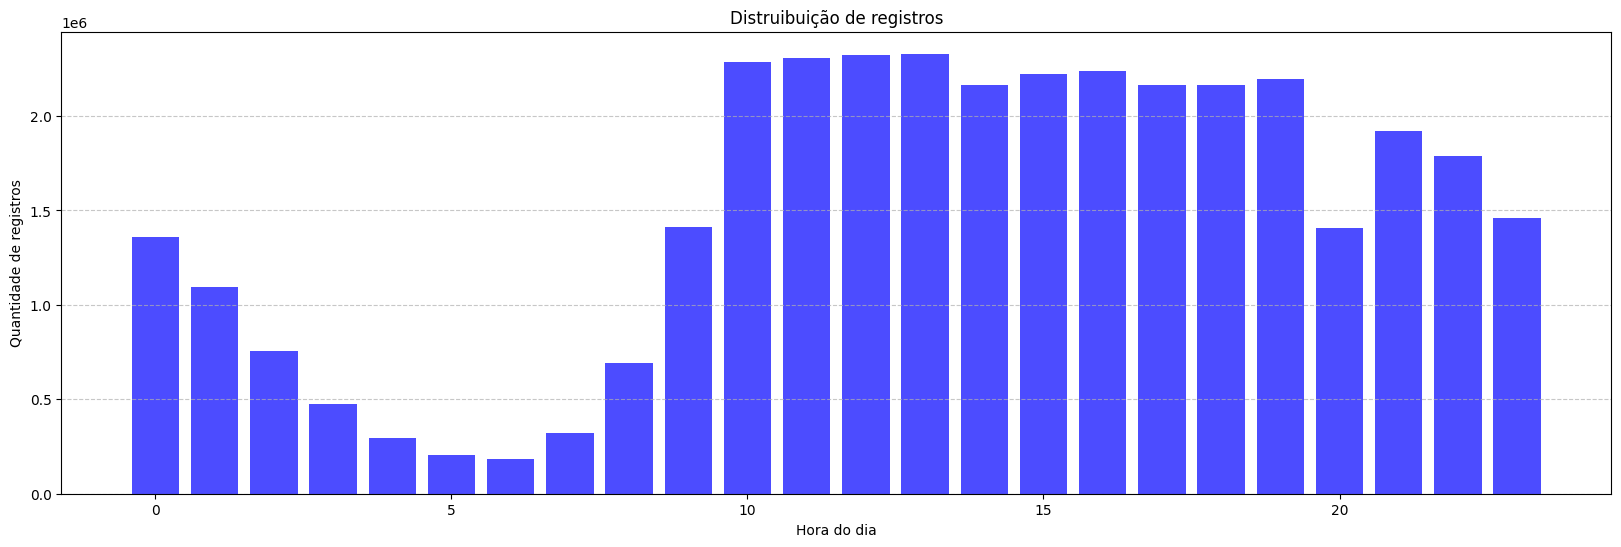

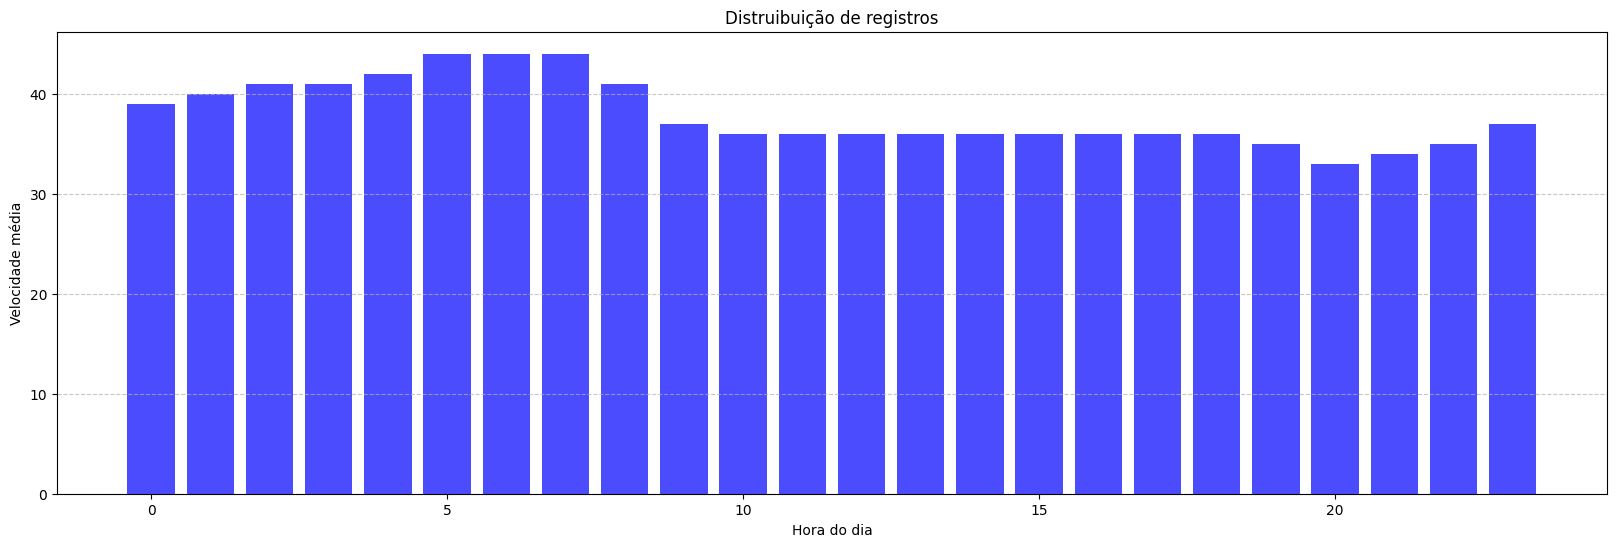

In [52]:
# Verificar a quantidades de nulls na tabela

query =  """
with radares_filtrados as (
    select *
    from `rj-cetrio.desafio.readings_2024_06`
    where camera_latitude between -23.100466 and -22.767821
      and camera_longitude between -43.807011 and -43.152521
)
select
    extract(hour from datahora) as hora,
    count(*) as quantidade_registros,
    avg(velocidade) as velocidade_media,
from
    radares_filtrados
group by
    hora
order by
    hora;
"""
df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df['velocidade_media'] = df['velocidade_media'].astype(int)
print(f'Velocidade média máxima :{df["velocidade_media"].max()} , Velocidade média mínima {df["velocidade_media"].min()}')

# Plotagem do gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(df['hora'], df['quantidade_registros'], color='blue', alpha=0.7)
plt.xlabel('Hora do dia')
plt.ylabel('Quantidade de registros')
plt.title('Distruibuição de registros')
#plt.xticks(df['velocidade'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plotagem do gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(df['hora'], df['velocidade_media'], color='blue', alpha=0.7)
plt.xlabel('Hora do dia')
plt.ylabel('Velocidade média')
plt.title('Distruibuição de registros')
#plt.xticks(df['velocidade'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Analisando empresas

In [75]:
query = '''
with radares_filtrados as (
    select *
    from `rj-cetrio.desafio.readings_2024_06`
    where camera_latitude between -23.100466 and -22.767821
      and camera_longitude between -43.807011 and -43.152521
)

select
    to_base64(empresa) as empresa,
    count(*) as num_registros
from
    radares_filtrados
group by
    empresa
order by
    num_registros desc;
'''

df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
print(f'Numero de registro{df["num_registros"].sum()}')
df



Downloading: 100%|██████████| 3/3 [00:00<00:00,  9.37rows/s]

Numero de registro35791719


,empresa,num_registros
0,HiVFr51Ixg==,23907671
1,CJGWe0E/pA==,8717449
2,LOAagMfz0A==,3166599


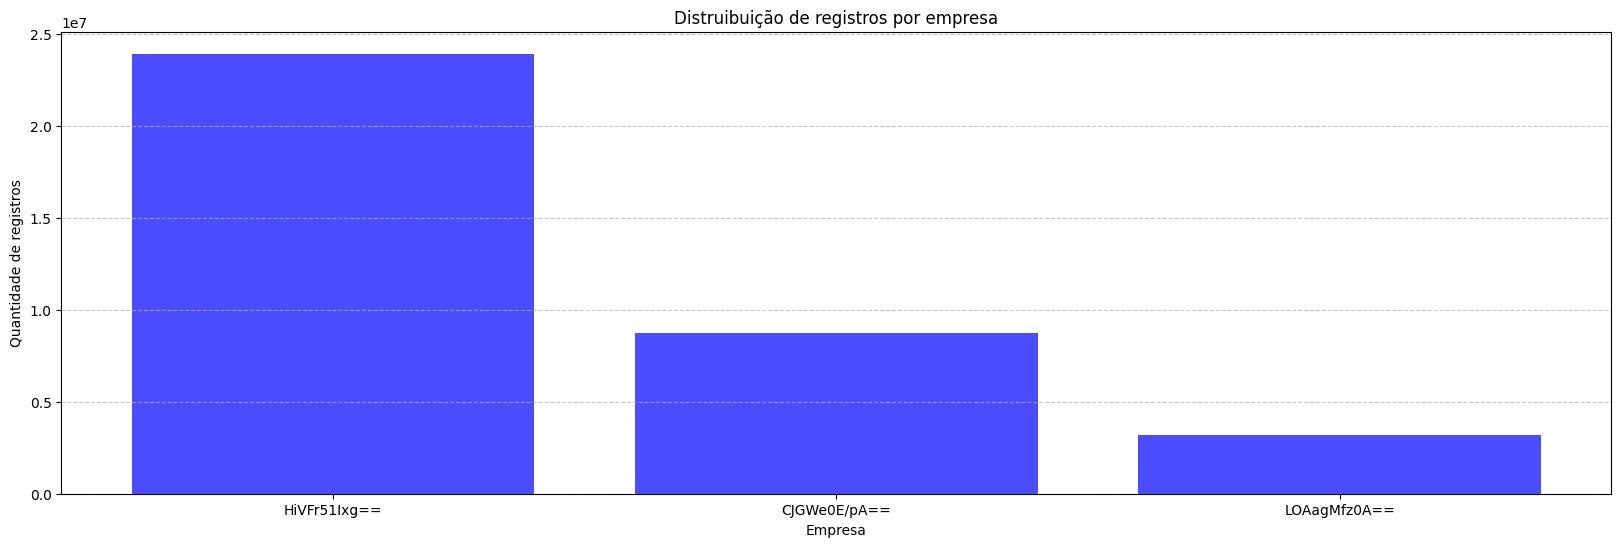

In [76]:
df['num_registros'] = df['num_registros'].astype(int)
# Plotagem do gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(df['empresa'], df['num_registros'], color='blue', alpha=0.7)
plt.xlabel('Empresa')
plt.ylabel('Quantidade de registros')
plt.title('Distruibuição de registros por empresa')
#plt.xticks(df['velocidade'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Velocidade média , máxima e minima

In [ ]:

query = '''
WITH radares_filtrados AS (
    SELECT *
    FROM `rj-cetrio.desafio.readings_2024_06`
    WHERE camera_latitude BETWEEN -23.100466 AND -22.767821
      AND camera_longitude BETWEEN -43.807011 AND -43.152521
)
select
    avg(velocidade) as velocidade_media,
    max(velocidade) as velocidade_maxima,
    min(velocidade) as velocidade_minima
from
    radares_filtrados;
'''

df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df



Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.82rows/s]


,velocidade_media,velocidade_maxima,velocidade_minima
0,37.080611,255,0


Vamos agora, ver como estão distribuídas essas velocidades

In [54]:
query = '''
WITH radares_filtrados AS (
    SELECT *
    FROM `rj-cetrio.desafio.readings_2024_06`
    WHERE camera_latitude BETWEEN -23.100466 AND -22.767821
      AND camera_longitude BETWEEN -43.807011 AND -43.152521
)
select
    velocidade,
    count(*) as quantidade
from
    radares_filtrados
group by
    velocidade
order by
    velocidade asc;

'''

df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df['velocidade'] = df['velocidade'].astype(int)
df



Downloading: 100%|██████████| 256/256 [00:00<00:00, 977.20rows/s]


,velocidade,quantidade
0,0,427019
1,1,41914
2,2,38273
3,3,51641
4,4,52867
...,...,...
251,251,42
252,252,24
253,253,21
254,254,50


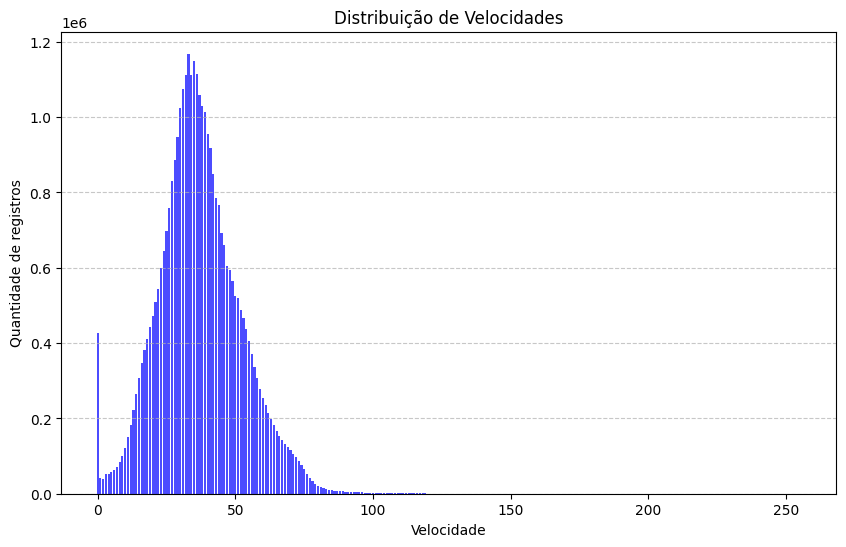

In [58]:
# Plotagem do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df['velocidade'], df['quantidade'], color='blue', alpha=0.7)
plt.xlabel('Velocidade')
plt.ylabel('Quantidade de registros')
plt.title('Distribuição de Velocidades')
#plt.xticks(df['velocidade'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

AGora, vamos excluir os 0km/hr para vermos como fica a nova média de velocidades

In [60]:

query = '''
WITH radares_filtrados AS (
    SELECT *
    FROM `rj-cetrio.desafio.readings_2024_06`
    WHERE camera_latitude BETWEEN -23.100466 AND -22.767821
      AND camera_longitude BETWEEN -43.807011 AND -43.152521
      and velocidade <> 0
)
select
    avg(velocidade) as velocidade_media,
    max(velocidade) as velocidade_maxima,
    min(velocidade) as velocidade_minima
from
    radares_filtrados;
'''

df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df




Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.81rows/s]


,velocidade_media,velocidade_maxima,velocidade_minima
0,37.52835,255,1


In [61]:
query = '''
WITH radares_filtrados AS (
    SELECT *
    FROM `rj-cetrio.desafio.readings_2024_06`
    WHERE camera_latitude BETWEEN -23.100466 AND -22.767821
      AND camera_longitude BETWEEN -43.807011 AND -43.152521
      and velocidade <> 0
)
select
    velocidade,
    count(*) as quantidade
from
    radares_filtrados
group by
    velocidade
order by
    velocidade asc;

'''

df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df['velocidade'] = df['velocidade'].astype(int)
df



Downloading: 100%|██████████| 255/255 [00:00<00:00, 864.48rows/s]


,velocidade,quantidade
0,1,41914
1,2,38273
2,3,51641
3,4,52867
4,5,58346
...,...,...
250,251,42
251,252,24
252,253,21
253,254,50


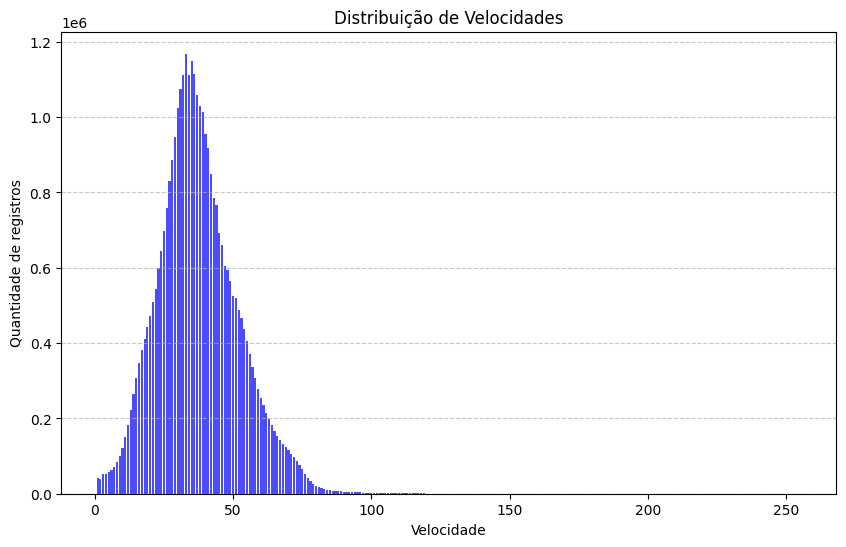

In [62]:
# Plotagem do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df['velocidade'], df['quantidade'], color='blue', alpha=0.7)
plt.xlabel('Velocidade')
plt.ylabel('Quantidade de registros')
plt.title('Distribuição de Velocidades')
#plt.xticks(df['velocidade'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [68]:
# Número de placas distintas
query = """
WITH radares_filtrados AS (
    SELECT *
    FROM `rj-cetrio.desafio.readings_2024_06`
    WHERE camera_latitude BETWEEN -23.100466 AND -22.767821
      AND camera_longitude BETWEEN -43.807011 AND -43.152521
)
select
  count(distinct placa) as numero_placas
from
  radares_filtrados"""
df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df


Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.67rows/s]


,numero_placas
0,7863888


In [66]:
query = '''
WITH radares_filtrados AS (
    SELECT *
    FROM `rj-cetrio.desafio.readings_2024_06`
    WHERE camera_latitude BETWEEN -23.100466 AND -22.767821
      AND camera_longitude BETWEEN -43.807011 AND -43.152521
)
select
    to_base64(tipoveiculo) as tipoveiculo,
    count(distinct placa) as quantidade
from
    radares_filtrados
group by
    tipoveiculo;
'''

df = bd.read_sql(query, billing_project_id="atomic-oven-387211")
df


Downloading: 100%|██████████| 4/4 [00:00<00:00, 15.80rows/s]


,tipoveiculo,quantidade
0,4uACn8DT5Q==,7671328
1,AxzAA36BbQ==,105457
2,emN29HypFQ==,507514
3,uIZSERCZ7Q==,89635


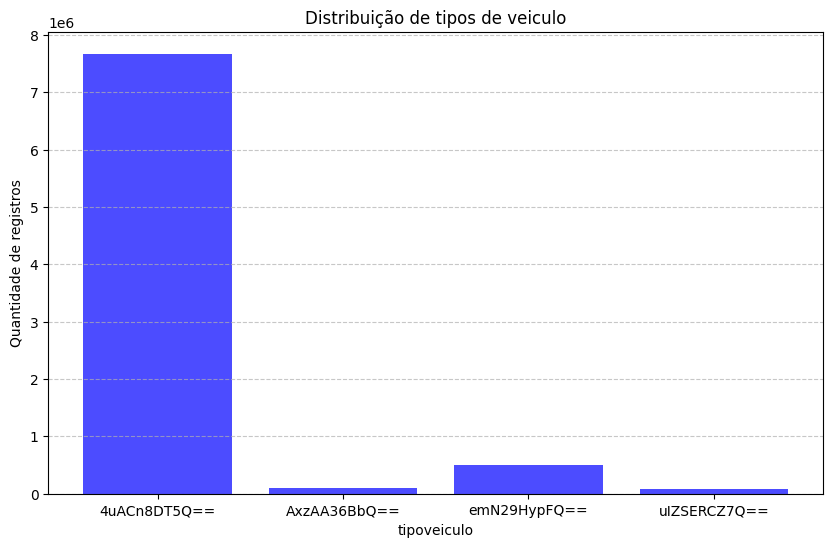

In [67]:
# Plotagem do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df['tipoveiculo'], df['quantidade'], color='blue', alpha=0.7)
plt.xlabel('tipoveiculo')
plt.ylabel('Quantidade de registros')
plt.title('Distribuição de tipos de veiculo')
#plt.xticks(df['velocidade'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()